# Muffin VS Chihuahua

Load the dataset from mounted google drive (originally from Kaggle https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip -q gdrive/MyDrive/Colab\ Notebooks/Muffin\ vs\ chihuahua/archive.zip -d data
!ls data

test  train


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

## Data preprocessing

Filter out some corrupted images in JPEG if exists

In [4]:
import os

num_skipped = 0
for folder_name in ("test", "train"):
    for img_type in ("chihuahua", "muffin"):
        folder_path = os.path.join("data", f"{folder_name}/{img_type}")
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                fobj = open(fpath, "rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


Create additional directories for managing cross-validation

In [5]:
import shutil
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

dest_root = "data/cross_validation"
labels = ["chihuahua", "muffin"]
if not os.path.exists(dest_root):
  os.mkdir(dest_root)
for i in range(1, 6):
  for ds in ["train", "validation"]:
    root_ds = dest_root + f"/{ds}_{i}"
    if not os.path.exists(root_ds):
        os.mkdir(root_ds)
    for label in labels:
      root_ds_label = root_ds + f"/{label}"
      if not os.path.exists(root_ds_label):
        os.mkdir(root_ds_label)

sources = {"chihuahua": "data/train/chihuahua", "muffin": "data/train/muffin"}
chihuahua_img_names = np.array([f for f in os.listdir(sources["chihuahua"])])
muffin_img_names = np.array([f for f in os.listdir(sources["muffin"])])
img_names = {"chihuahua": chihuahua_img_names, "muffin": muffin_img_names}

kf = KFold(n_splits=5, shuffle=True, random_state=69)
for label in ["chihuahua", "muffin"]:
  for i, (train_indices, val_indices) in tqdm(enumerate(kf.split(img_names[label]))):
    for img_name in img_names[label][train_indices]:
      shutil.copy(f"{sources[label]}/{img_name}", f"data/cross_validation/train_{i + 1}/{label}/{img_name}")
    for img_name in img_names[label][val_indices]:
      shutil.copy(f"{sources[label]}/{img_name}", f"data/cross_validation/validation_{i + 1}/{label}/{img_name}")

kfold_dirs = [{"train": f"{dest_root}/train_{i}", "validation": f"{dest_root}/validation_{i}"} for i in range(1, 6)]
kfold_dirs

0it [00:00, ?it/s]

0it [00:00, ?it/s]

[{'train': 'data/cross_validation/train_1',
  'validation': 'data/cross_validation/validation_1'},
 {'train': 'data/cross_validation/train_2',
  'validation': 'data/cross_validation/validation_2'},
 {'train': 'data/cross_validation/train_3',
  'validation': 'data/cross_validation/validation_3'},
 {'train': 'data/cross_validation/train_4',
  'validation': 'data/cross_validation/validation_4'},
 {'train': 'data/cross_validation/train_5',
  'validation': 'data/cross_validation/validation_5'}]

In [6]:
print("Train chihuahua images %d" % len(img_names["chihuahua"]))
print("Train muffin images %d" % len (img_names["muffin"]))

Train chihuahua images 2559
Train muffin images 2174


Generate a Keras dataset

In [7]:
image_size = (128, 128)
batch_size = 128

print("Train dataset and validation dataset")
train, val = tf.keras.utils.image_dataset_from_directory(
    "data/train",
    validation_split=0.2,
    subset="both",
    seed=69,
    image_size=image_size,
    batch_size=batch_size,
)

print("\nTrain_val dataset")
train_val = tf.keras.utils.image_dataset_from_directory(
    "data/train",
    image_size=image_size,
    batch_size=None,
    seed=69
)

print("\nTest dataset")
test = tf.keras.utils.image_dataset_from_directory(
    "data/test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

print("\nKFold dataset")
kfold_datasets = []
for paths in kfold_dirs:
  ktrain = tf.keras.utils.image_dataset_from_directory(
    paths["train"],
    image_size=image_size,
    batch_size=batch_size,
    seed=69
  )
  kvalidation = tf.keras.utils.image_dataset_from_directory(
    paths["validation"],
    image_size=image_size,
    batch_size=batch_size,
    seed=69
  )
  kfold_datasets.append({"train": ktrain, "validation": kvalidation})

Train dataset and validation dataset
Found 4733 files belonging to 2 classes.
Using 3787 files for training.
Using 946 files for validation.

Train_val dataset
Found 4733 files belonging to 2 classes.

Test dataset
Found 1184 files belonging to 2 classes.

KFold dataset
Found 3786 files belonging to 2 classes.
Found 947 files belonging to 2 classes.
Found 3786 files belonging to 2 classes.
Found 947 files belonging to 2 classes.
Found 3786 files belonging to 2 classes.
Found 947 files belonging to 2 classes.
Found 3786 files belonging to 2 classes.
Found 947 files belonging to 2 classes.
Found 3788 files belonging to 2 classes.
Found 945 files belonging to 2 classes.


Visualize some images

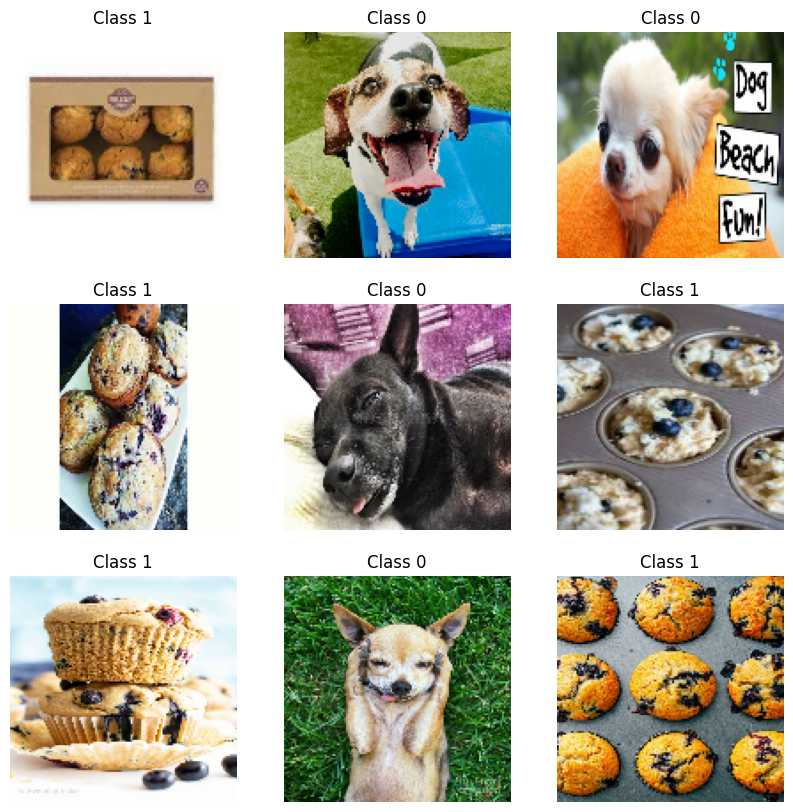

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Class {int(labels[i])}")
        plt.axis("off")

## Make a small model architecture

Model with 5377 parameters


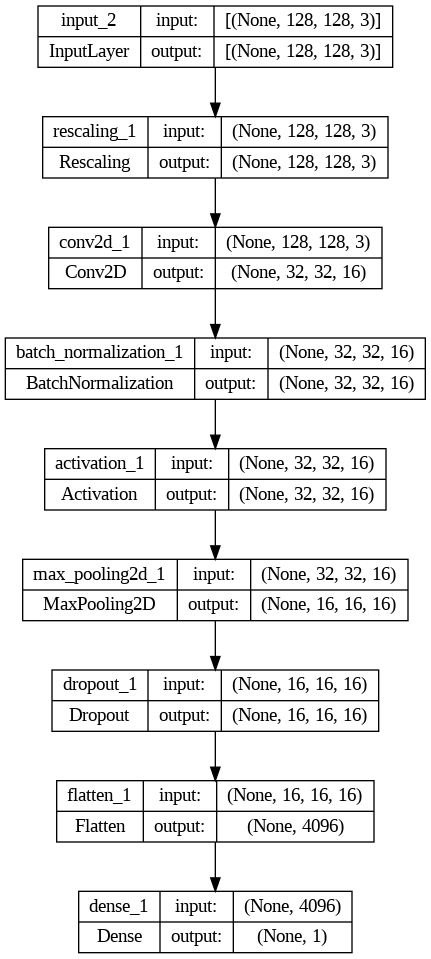

In [ ]:
def make_small_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 5, strides=4, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_small_model(input_shape=image_size + (3,))

print("Model with %d parameters" % model.count_params())
keras.utils.plot_model(model, show_shapes=True)

### Cross-validation

In [ ]:
cv_train_scores, cv_val_scores = [], []

for ds in kfold_datasets:
  small_model = make_small_model(input_shape=image_size + (3,))
  small_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
  )
  callbacks = small_model.fit(
      ds["train"],
      epochs=15,
      validation_data=ds["validation"]
  )
  cv_train_scores.append(callbacks.history['accuracy'][-1])
  cv_val_scores.append(callbacks.history['val_accuracy'][-1])

Epoch 1/15
30/30 [==============================] - 23s 613ms/step - loss: 0.7448 - accuracy: 0.6286 - val_loss: 0.8146 - val_accuracy: 0.5417
Epoch 2/15
30/30 [==============================] - 21s 570ms/step - loss: 0.4973 - accuracy: 0.7739 - val_loss: 1.0889 - val_accuracy: 0.5417
Epoch 3/15
30/30 [==============================] - 26s 783ms/step - loss: 0.4410 - accuracy: 0.8045 - val_loss: 0.7942 - val_accuracy: 0.5576
Epoch 4/15
30/30 [==============================] - 25s 697ms/step - loss: 0.4125 - accuracy: 0.8156 - val_loss: 0.8394 - val_accuracy: 0.5565
Epoch 5/15
30/30 [==============================] - 23s 671ms/step - loss: 0.3748 - accuracy: 0.8352 - val_loss: 0.8527 - val_accuracy: 0.5576
Epoch 6/15
30/30 [==============================] - 20s 583ms/step - loss: 0.3729 - accuracy: 0.8373 - val_loss: 0.8170 - val_accuracy: 0.5660
Epoch 7/15
30/30 [==============================] - 21s 548ms/step - loss: 0.3431 - accuracy: 0.8529 - val_loss: 0.7909 - val_accuracy: 0.5797

In [ ]:
print("SMALL MODEL 5-fold CV train accuracy %.2f and validation accuracy %.2f" % (np.mean(cv_train_scores), np.mean(cv_val_scores)))

SMALL MODEL 5-fold CV train accuracy 0.89 and validation accuracy 0.81


Test set evaluation

In [ ]:
small_model = make_small_model(input_shape=image_size + (3,))
small_model.compile(
  optimizer=keras.optimizers.Adam(1e-3),
  loss="binary_crossentropy",
  metrics=["accuracy"]
)
callbacks = small_model.fit(
    train,
    epochs=15,
    validation_data=test
)

Epoch 1/15
30/30 [==============================] - 23s 596ms/step - loss: 0.7711 - accuracy: 0.6182 - val_loss: 0.8244 - val_accuracy: 0.5405
Epoch 2/15
30/30 [==============================] - 21s 603ms/step - loss: 0.5168 - accuracy: 0.7568 - val_loss: 1.0759 - val_accuracy: 0.5405
Epoch 3/15
30/30 [==============================] - 24s 610ms/step - loss: 0.4633 - accuracy: 0.7954 - val_loss: 1.1323 - val_accuracy: 0.5405
Epoch 4/15
30/30 [==============================] - 20s 556ms/step - loss: 0.4119 - accuracy: 0.8220 - val_loss: 0.9344 - val_accuracy: 0.5397
Epoch 5/15
30/30 [==============================] - 26s 727ms/step - loss: 0.3904 - accuracy: 0.8350 - val_loss: 0.8135 - val_accuracy: 0.5473
Epoch 6/15
30/30 [==============================] - 21s 551ms/step - loss: 0.3600 - accuracy: 0.8447 - val_loss: 0.7116 - val_accuracy: 0.5633
Epoch 7/15
30/30 [==============================] - 21s 590ms/step - loss: 0.3442 - accuracy: 0.8529 - val_loss: 0.5854 - val_accuracy: 0.6368

In [ ]:
print('Test loss %.2f' % callbacks.history['val_loss'][-1])
print("Test accuracy %.2f" % callbacks.history['val_accuracy'][-1])

Test loss 0.39
Test accuracy 0.81


## Medium model architecture

Model with 23873 parameters


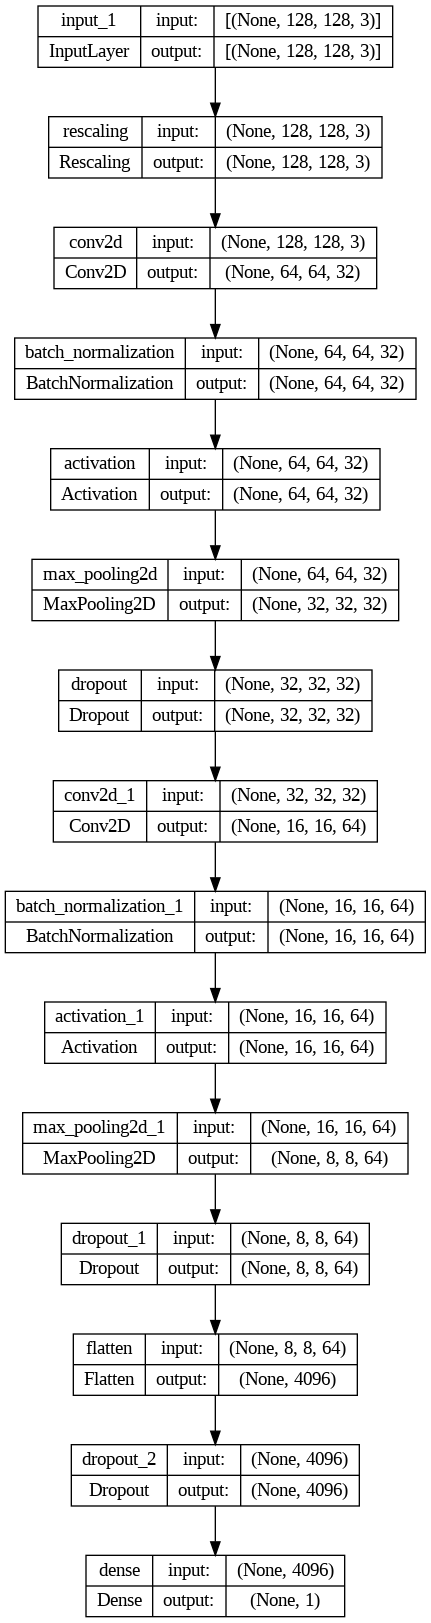

In [9]:
def make_medium_model(input_shape, dropout_rate=0.25):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)

    # x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_medium_model(input_shape=image_size + (3,))

print("Model with %d parameters" % model.count_params())
keras.utils.plot_model(model, show_shapes=True)

### Hyperparameter tuning

In [ ]:
from tqdm.notebook import tqdm

epochs = 10
dropout_rates = np.array(range(5, 100, 5)) / 100
train_losses, train_scores = [], []
val_losses, val_scores = [], []

for dropout_rate in tqdm(dropout_rates):
  model = make_medium_model(input_shape=image_size + (3,), dropout_rate=dropout_rate)
  model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
  )
  callbacks = model.fit(
    train,
    epochs=epochs,
    validation_data=val
  )
  train_losses.append(callbacks.history['loss'][-1])
  train_scores.append(callbacks.history['accuracy'][-1])
  val_losses.append(callbacks.history['val_loss'][-1])
  val_scores.append(callbacks.history['val_accuracy'][-1])

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/10
119/119 [==============================] - 40s 315ms/step - loss: 0.4559 - accuracy: 0.8025 - val_loss: 1.2589 - val_accuracy: 0.5328
Epoch 2/10
119/119 [==============================] - 38s 311ms/step - loss: 0.3142 - accuracy: 0.8733 - val_loss: 1.9330 - val_accuracy: 0.5328
Epoch 3/10
119/119 [==============================] - 39s 313ms/step - loss: 0.2881 - accuracy: 0.8833 - val_loss: 1.3246 - val_accuracy: 0.5444
Epoch 4/10
119/119 [==============================] - 38s 310ms/step - loss: 0.2311 - accuracy: 0.9105 - val_loss: 0.6124 - val_accuracy: 0.7431
Epoch 5/10
119/119 [==============================] - 38s 312ms/step - loss: 0.2190 - accuracy: 0.9115 - val_loss: 1.0888 - val_accuracy: 0.6702
Epoch 6/10
119/119 [==============================] - 43s 352ms/step - loss: 0.1981 - accuracy: 0.9221 - val_loss: 0.3146 - val_accuracy: 0.8763
Epoch 7/10
119/119 [==============================] - 38s 311ms/step - loss: 0.1810 - accuracy: 0.9250 - val_loss: 0.7210 - val_ac

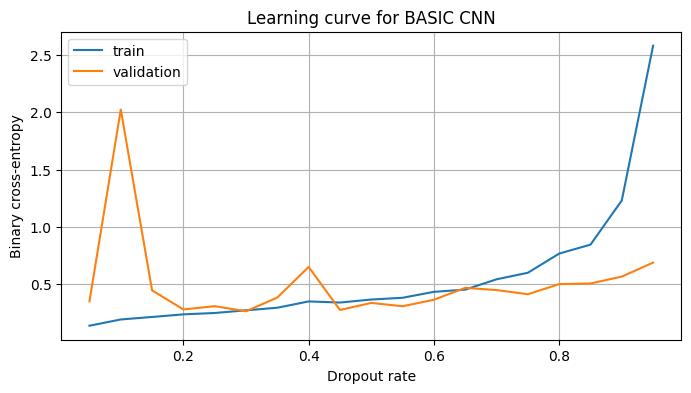

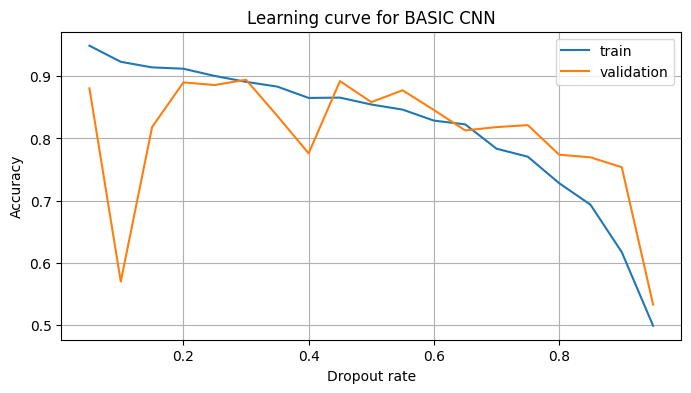

In [ ]:
import seaborn as sns

def plot_learning_curve(parameters, train_scores, val_scores, param_name="", score_name="", title=""):
  fig, ax = plt.subplots(figsize=(8, 4))
  plt.grid()
  sns.lineplot(x=parameters, y=train_scores, label="train")
  sns.lineplot(x=parameters, y=val_scores, label="validation")
  plt.xlabel(param_name)
  plt.ylabel(score_name)
  plt.title(title)
  return fig

for tr, va, name in zip([train_losses, train_scores], [val_losses, val_scores], ["Binary cross-entropy", "Accuracy"]):
  plot_learning_curve(dropout_rates, tr, va, "Dropout rate", name, "Learning curve for BASIC CNN")

### Cross-validation

In [10]:
best_base_dropout_rate = 0.3
best_base_epochs = 10

In [ ]:
cv_train_scores, cv_val_scores = [], []

for ds in kfold_datasets:
  best_medium_model = make_medium_model(input_shape=image_size + (3,), dropout_rate=best_base_dropout_rate)
  best_medium_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
  )
  callbacks = best_medium_model.fit(
      ds["train"],
      epochs=best_base_epochs,
      validation_data=ds["validation"]
  )
  cv_train_scores.append(callbacks.history['accuracy'][-1])
  cv_val_scores.append(callbacks.history['val_accuracy'][-1])

Epoch 1/10
119/119 [==============================] - 46s 362ms/step - loss: 0.7416 - accuracy: 0.7161 - val_loss: 1.4916 - val_accuracy: 0.5407
Epoch 2/10
119/119 [==============================] - 42s 340ms/step - loss: 0.5012 - accuracy: 0.8090 - val_loss: 2.1895 - val_accuracy: 0.5407
Epoch 3/10
119/119 [==============================] - 48s 396ms/step - loss: 0.4242 - accuracy: 0.8339 - val_loss: 1.5730 - val_accuracy: 0.5449
Epoch 4/10
119/119 [==============================] - 43s 357ms/step - loss: 0.3852 - accuracy: 0.8428 - val_loss: 0.4631 - val_accuracy: 0.7856
Epoch 5/10
119/119 [==============================] - 42s 349ms/step - loss: 0.3598 - accuracy: 0.8621 - val_loss: 0.7374 - val_accuracy: 0.7138
Epoch 6/10
119/119 [==============================] - 45s 366ms/step - loss: 0.3487 - accuracy: 0.8666 - val_loss: 0.4811 - val_accuracy: 0.7624
Epoch 7/10
119/119 [==============================] - 42s 341ms/step - loss: 0.3489 - accuracy: 0.8616 - val_loss: 0.2359 - val_ac

In [ ]:
print("5-fold CV train accuracy %.2f and validation accuracy %.2f" % (np.mean(cv_train_scores), np.mean(cv_val_scores)))

5-fold CV train accuracy 0.89 and validation accuracy 0.87


### Model evaluation

Get the overall test score on unseen images

In [17]:
best_medium_model = make_medium_model(input_shape=image_size + (3,), dropout_rate=best_base_dropout_rate)
best_medium_model.compile(
  optimizer=keras.optimizers.Adam(1e-3),
  loss="binary_crossentropy",
  metrics=["accuracy"]
)
callbacks = best_medium_model.fit(
    train,
    epochs=best_base_epochs,
    validation_data=test
)

Epoch 1/20
30/30 [==============================] - 54s 2s/step - loss: 3.1731 - accuracy: 0.6367 - val_loss: 6.3176 - val_accuracy: 0.5405
Epoch 2/20
30/30 [==============================] - 48s 2s/step - loss: 0.6228 - accuracy: 0.7851 - val_loss: 2.1188 - val_accuracy: 0.5405
Epoch 3/20
30/30 [==============================] - 50s 2s/step - loss: 0.4541 - accuracy: 0.8215 - val_loss: 2.0530 - val_accuracy: 0.5405
Epoch 4/20
30/30 [==============================] - 47s 1s/step - loss: 0.3946 - accuracy: 0.8468 - val_loss: 1.2208 - val_accuracy: 0.5414
Epoch 5/20
30/30 [==============================] - 50s 2s/step - loss: 0.3550 - accuracy: 0.8582 - val_loss: 1.3325 - val_accuracy: 0.5405
Epoch 6/20
30/30 [==============================] - 50s 2s/step - loss: 0.3346 - accuracy: 0.8685 - val_loss: 2.6532 - val_accuracy: 0.5405
Epoch 7/20
30/30 [==============================] - 48s 1s/step - loss: 0.3176 - accuracy: 0.8733 - val_loss: 1.2461 - val_accuracy: 0.5448
Epoch 8/20
30/30 [==

In [18]:
print('Test loss %.2f' % callbacks.history['val_loss'][-1])
print("Test accuracy %.2f" % callbacks.history['val_accuracy'][-1])

Test loss 0.26
Test accuracy 0.90


Visuzalize images which were classified the best and missclassified the worst

In [20]:
test_file_paths = np.array(test.file_paths)
raw_test_labels = []
for _, label in test.as_numpy_iterator():
  raw_test_labels.append(label)
raw_test_labels = np.concatenate(raw_test_labels)

test_preds = best_medium_model.predict(test)
test_preds = np.concatenate(test_preds)

10/10 [==============================] - 6s 577ms/step


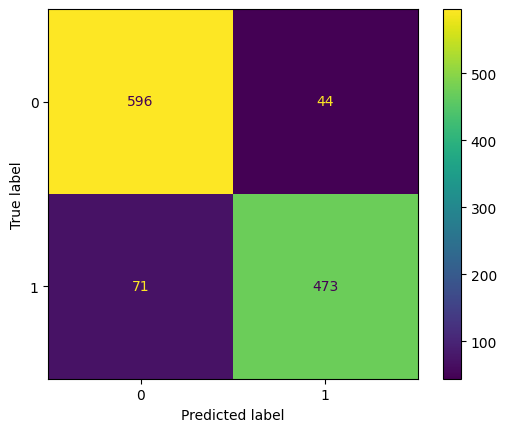

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_label_preds = [1 if t > 0.5 else 0 for t in test_preds]
cm = confusion_matrix(raw_test_labels, test_label_preds)
ConfusionMatrixDisplay(cm).plot();

In [ ]:
top_tp = test_file_paths[raw_test_labels == 1][np.argsort(test_preds[raw_test_labels == 1])[::-1]]
top_fn = top_tp[::-1]
top_tn = test_file_paths[raw_test_labels == 0][np.argsort(test_preds[raw_test_labels == 0])]
top_fp = top_tn[::-1]

In [ ]:
def visualize_top3_preds(paths, model, title=""):
  fig = plt.figure(figsize=(10, 3))
  fig.suptitle(title)
  for i, path in enumerate(paths[:3]):
    img = keras.utils.load_img(path, target_size=image_size)
    img_batch = tf.expand_dims(img, 0)
    score = float(model.predict(img_batch, verbose=0)[0][0])

    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{100 * (1 - score):.5f}% chihuahua; \n {100 * score:.5f}% muffin.")
    plt.axis("off")
  fig.subplots_adjust(top=0.7)

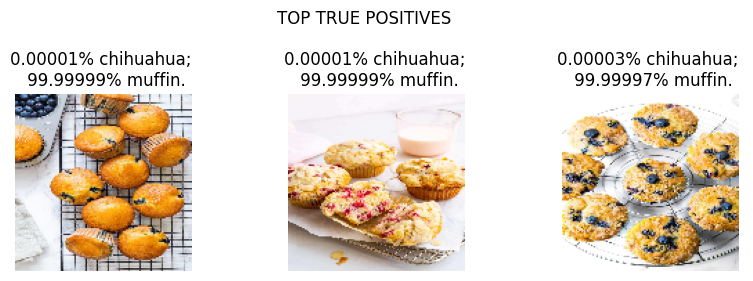

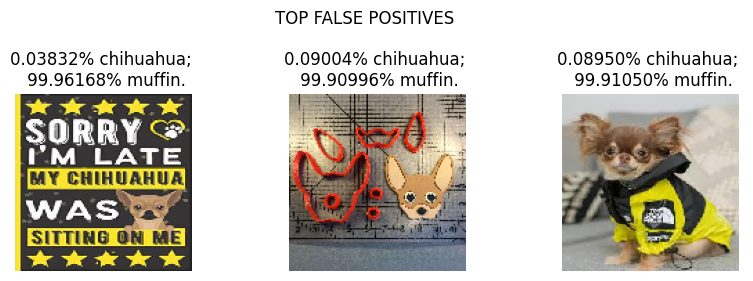

In [ ]:
visualize_top3_preds(paths=top_tp, model=best_medium_model, title="TOP TRUE POSITIVES")
visualize_top3_preds(paths=top_fp, model=best_medium_model, title="TOP FALSE POSITIVES")

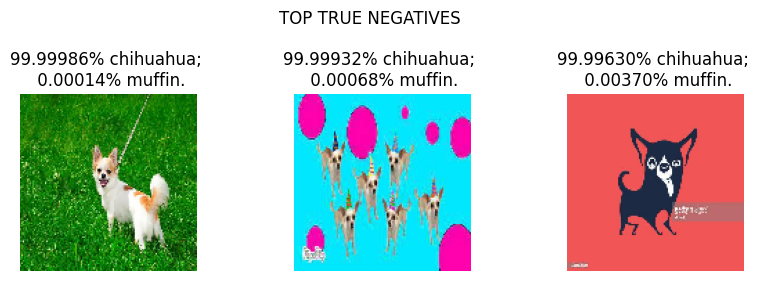

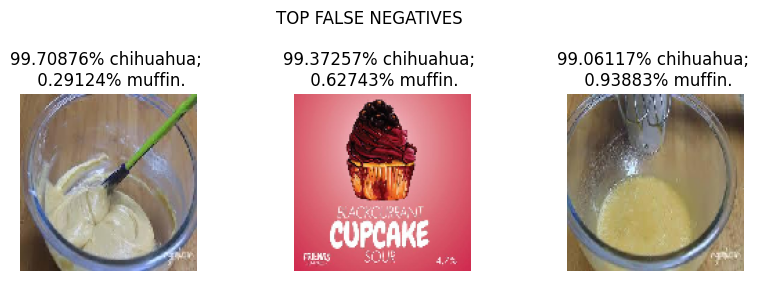

In [ ]:
visualize_top3_preds(paths=top_tn, model=best_medium_model, title="TOP TRUE NEGATIVES")
visualize_top3_preds(paths=top_fn, model=best_medium_model, title="TOP FALSE NEGATIVES")

## Large model architecture

Model with 94657 parameters


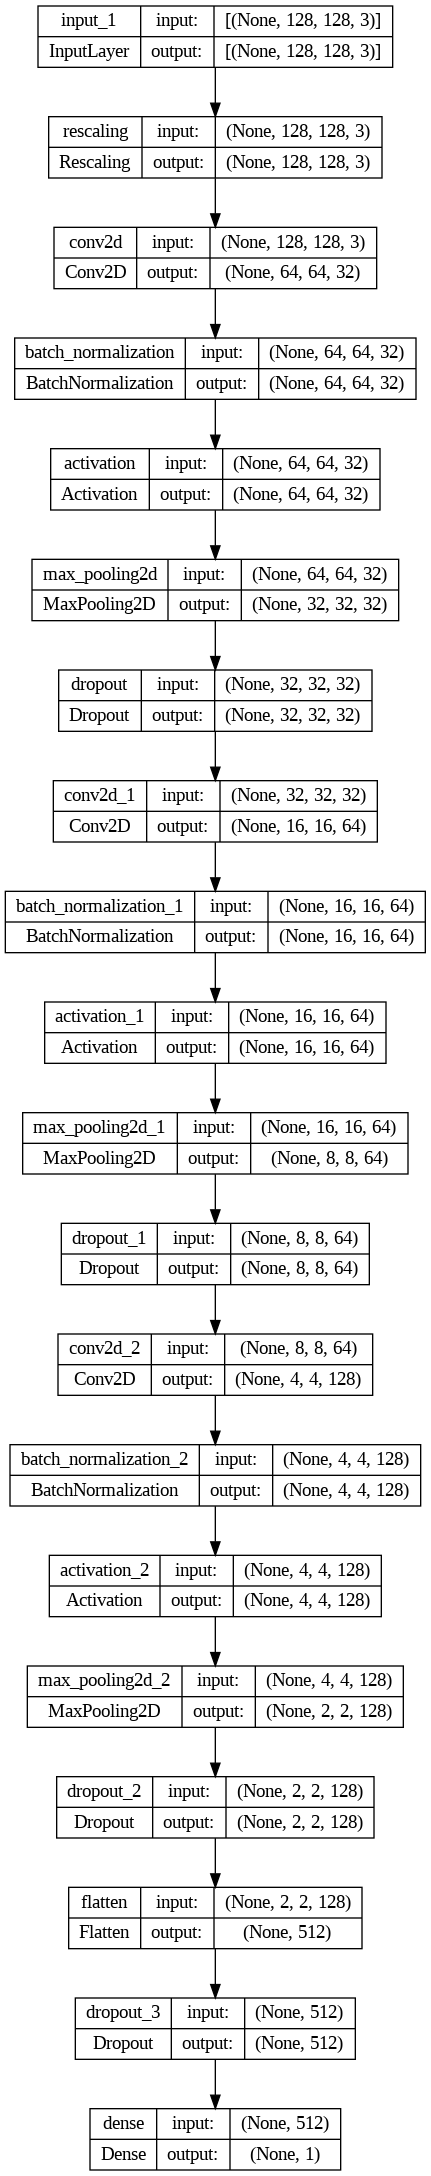

In [ ]:
def make_large_model(input_shape, dropout_rate=0.25):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = make_large_model(input_shape=image_size + (3,))

print("Model with %d parameters" % model.count_params())
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
cv_train_scores, cv_val_scores = [], []

for ds in kfold_datasets:
  large_model = make_large_model(input_shape=image_size + (3,))
  large_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
  )
  callbacks = large_model.fit(
      ds["train"],
      epochs=10,
      validation_data=ds["validation"]
  )
  cv_train_scores.append(callbacks.history['accuracy'][-1])
  cv_val_scores.append(callbacks.history['val_accuracy'][-1])

Epoch 1/10
30/30 [==============================] - 48s 1s/step - loss: 0.7078 - accuracy: 0.7066 - val_loss: 0.7394 - val_accuracy: 0.5407
Epoch 2/10
30/30 [==============================] - 55s 2s/step - loss: 0.5069 - accuracy: 0.7966 - val_loss: 0.9325 - val_accuracy: 0.5407
Epoch 3/10
30/30 [==============================] - 48s 1s/step - loss: 0.4079 - accuracy: 0.8381 - val_loss: 1.2408 - val_accuracy: 0.5407
Epoch 4/10
30/30 [==============================] - 51s 2s/step - loss: 0.3749 - accuracy: 0.8487 - val_loss: 1.4757 - val_accuracy: 0.5407
Epoch 5/10
30/30 [==============================] - 43s 1s/step - loss: 0.3493 - accuracy: 0.8619 - val_loss: 1.6830 - val_accuracy: 0.5407
Epoch 6/10
30/30 [==============================] - 42s 1s/step - loss: 0.3256 - accuracy: 0.8693 - val_loss: 1.6647 - val_accuracy: 0.5407
Epoch 7/10
30/30 [==============================] - 43s 1s/step - loss: 0.3103 - accuracy: 0.8782 - val_loss: 1.8752 - val_accuracy: 0.5407
Epoch 8/10
30/30 [==

In [ ]:
print("Large Model 5-fold CV train accuracy %.2f and validation accuracy %.2f" % (np.mean(cv_train_scores), np.mean(cv_val_scores)))

Large Model 5-fold CV train accuracy 0.89 and validation accuracy 0.54


Model is obviously overfits, let's add some data augmentation to increase the training set and reduce the overfitting

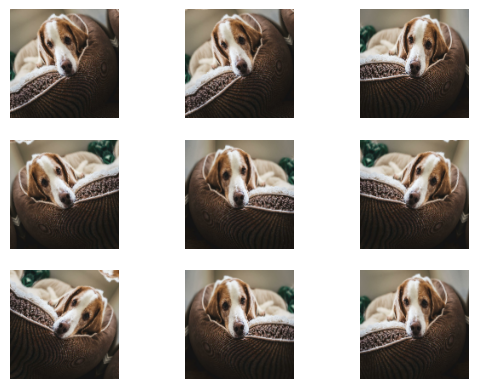

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

for images, _ in train.take(3):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [ ]:
for i, ds in enumerate(kfold_datasets):
  ds_train = ds["train"].map(
      lambda img, label: (data_augmentation(img), label),
      num_parallel_calls=tf.data.AUTOTUNE,
  ).prefetch(tf.data.AUTOTUNE)
  ds["train"] = ds_train

In [ ]:
cv_train_scores, cv_val_scores = [], []

for ds in kfold_datasets:
  large_model = make_large_model(input_shape=image_size + (3,))
  large_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
  )
  callbacks = large_model.fit(
      ds["train"],
      epochs=10,
      validation_data=ds["validation"]
  )
  cv_train_scores.append(callbacks.history['accuracy'][-1])
  cv_val_scores.append(callbacks.history['val_accuracy'][-1])

Epoch 1/10
30/30 [==============================] - 51s 1s/step - loss: 0.7459 - accuracy: 0.6891 - val_loss: 0.7177 - val_accuracy: 0.5407
Epoch 2/10
30/30 [==============================] - 46s 1s/step - loss: 0.4910 - accuracy: 0.7995 - val_loss: 0.9995 - val_accuracy: 0.5407
Epoch 3/10
30/30 [==============================] - 46s 1s/step - loss: 0.4292 - accuracy: 0.8228 - val_loss: 1.2601 - val_accuracy: 0.5407
Epoch 4/10
30/30 [==============================] - 45s 1s/step - loss: 0.4065 - accuracy: 0.8333 - val_loss: 1.4136 - val_accuracy: 0.5407
Epoch 5/10
30/30 [==============================] - 47s 1s/step - loss: 0.3610 - accuracy: 0.8539 - val_loss: 1.5521 - val_accuracy: 0.5407
Epoch 6/10
30/30 [==============================] - 47s 1s/step - loss: 0.3393 - accuracy: 0.8608 - val_loss: 1.7863 - val_accuracy: 0.5407
Epoch 7/10
30/30 [==============================] - 52s 2s/step - loss: 0.3319 - accuracy: 0.8695 - val_loss: 1.7539 - val_accuracy: 0.5407
Epoch 8/10
30/30 [==

In [ ]:
print("Large Model 5-fold CV train accuracy %.2f and validation accuracy %.2f" % (np.mean(cv_train_scores), np.mean(cv_val_scores)))

Large Model 5-fold CV train accuracy 0.88 and validation accuracy 0.54
